# Skeletonization using Proxies

In [1]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as pt

import scipy.linalg.interpolative as sli

eps = 1e-7

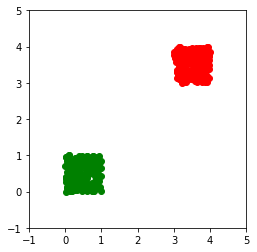

In [2]:
sources = np.random.rand(2, 200)
targets = np.random.rand(2, 200) + 3

pt.plot(sources[0], sources[1], "go")
pt.plot(targets[0], targets[1], "ro")

pt.xlim([-1, 5])
pt.ylim([-1, 5])

pt.gca().set_aspect("equal")

In [27]:
def interaction_mat(t, s):
    all_distvecs = s.reshape(2, 1, -1) - t.reshape(2, -1, 1)
    dists = np.sqrt(np.sum(all_distvecs**2, axis=0))
    return np.log(dists)

In [28]:
def numerical_rank(A, eps):
    _, sigma, _ = la.svd(A)
    return np.sum(sigma >= eps)

Check the interaction rank:

In [29]:
#clear
numerical_rank(interaction_mat(targets, sources), eps)

9

**Idea:**

* Don't want to build whole matrix to find the few rows/columns that actually matter.
* Introduces "proxies" that stand in for
    * *all sources outside the targets* or
    * *all targets outside these sources*

## Target Skeletonization

In [30]:
nproxies = 25

angles = np.linspace(0, 2*np.pi, nproxies)
target_proxies = 3.5 + 1.5 * np.array([np.cos(angles), np.sin(angles)])

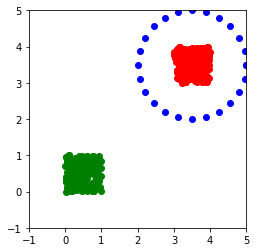

In [31]:
pt.plot(sources[0], sources[1], "go")
pt.plot(targets[0], targets[1], "ro")
pt.plot(target_proxies[0], target_proxies[1], "bo")

pt.xlim([-1, 5])
pt.ylim([-1, 5])

pt.gca().set_aspect("equal")

Construct the interaction matrix *from* the target proxies *to* the targets as `target_proxy_mat`.

**A note on terminology:** The `target_proxies` are *near* the targets but *stand in* for far-away sources.

In [32]:
#clear
target_proxy_mat = interaction_mat(targets, target_proxies)

Check its numerical rank and shape:

In [33]:
#clear
numerical_rank(target_proxy_mat, eps)

24

In [34]:
#clear
target_proxy_mat.shape

(200, 25)

Now compute an ID (row or column?):

In [35]:
#clear
idx, proj = sli.interp_decomp(target_proxy_mat.T, nproxies)

Find the target skeleton as `target_skeleton`, i.e. the indices of the targets from which the remaining values can be recovered:

In [36]:
#clear
target_skeleton = idx[:nproxies]

Check that the ID does what is promises:

In [37]:
P = np.hstack([np.eye(nproxies), proj])[:,np.argsort(idx)]
tpm_approx = P.T @ target_proxy_mat[target_skeleton]

la.norm(tpm_approx - target_proxy_mat, 2)

6.738945834835623e-15

Plot the chosen "skeleton" and the proxies:

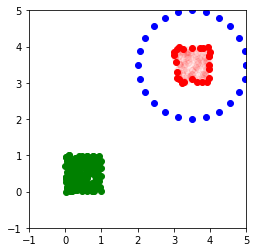

In [38]:
pt.plot(sources[0], sources[1], "go")
pt.plot(targets[0], targets[1], "ro", alpha=0.05)
pt.plot(targets[0, target_skeleton], targets[1, target_skeleton], "ro")
pt.plot(target_proxies[0], target_proxies[1], "bo")

pt.xlim([-1, 5])
pt.ylim([-1, 5])

pt.gca().set_aspect("equal")

What does this mean?

* We have now got a moral equivalent to a local expansion: The point values at the target skeleton points.
* Is it a coincidence that the skeleton points sit at the boundary of the target region?
* How many target proxies should we choose?
* Can cheaply recompute potential at any target from those few points.
* Have thus reduce LA-based evaluation cost to same as expansion-based cost.

Can we come up with an equivalent of a multipole expansion?

----------------

Check that this works for 'our' sources:

In [16]:
imat_error = (
    P.T.dot(interaction_mat(targets[:, target_skeleton], sources))
    -
    interaction_mat(targets, sources))

la.norm(imat_error, 2)

1.8776453951593488e-09

## Source Skeletonization

In [17]:
nproxies = 25

angles = np.linspace(0, 2*np.pi, nproxies)
source_proxies = 0.5 + 1.5 * np.array([np.cos(angles), np.sin(angles)])

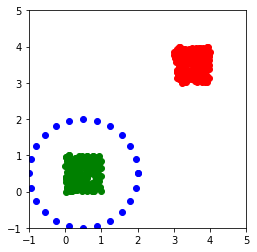

In [18]:
pt.plot(sources[0], sources[1], "go")
pt.plot(targets[0], targets[1], "ro")
pt.plot(source_proxies[0], source_proxies[1], "bo")

pt.xlim([-1, 5])
pt.ylim([-1, 5])

pt.gca().set_aspect("equal")

Construct the interaction matrix *from* the sources *to* the source proxies as `source_proxy_mat`:

**A note on terminology:** The `source_proxies` are *near* the sources but *stand in* for far-away targets.

In [19]:
#clear
source_proxy_mat = interaction_mat(source_proxies, sources)

In [20]:
source_proxy_mat.shape

(25, 200)

Now compute an ID (row or column?):

In [21]:
#clear
idx, proj = sli.interp_decomp(source_proxy_mat, nproxies)

In [22]:
#clear
source_skeleton = idx[:nproxies]

In [23]:
P = np.hstack([np.eye(nproxies), proj])[:,np.argsort(idx)]
tsm_approx = source_proxy_mat[:, source_skeleton].dot(P)

la.norm(tsm_approx - source_proxy_mat, 2)

5.2523961564651685e-15

Plot the chosen skeleton as well as the proxies:

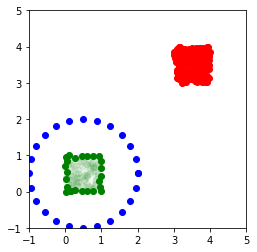

In [24]:
pt.plot(sources[0], sources[1], "go", alpha=0.05)
pt.plot(targets[0], targets[1], "ro")
pt.plot(sources[0, source_skeleton], sources[1, source_skeleton], "go")
pt.plot(source_proxies[0], source_proxies[1], "bo")

pt.xlim([-1, 5])
pt.ylim([-1, 5])

pt.gca().set_aspect("equal")

Check that it works for 'our' targets:

In [25]:
imat_error = (
    interaction_mat(targets, sources[:, source_skeleton]) @ P
    -
    interaction_mat(targets, sources))

la.norm(imat_error, 2)

5.966880531704515e-09

* Sensibly, this is just the transpose of the target skeletonization process.
    * For a given point cluster, the same skeleton can serve for target and source skeletonization!
* Computationally, starting from your original charges $x$, you accumulate 'new' charges $Px$ at the skeleton points and then *only* compute the interaction from the source skeleton to the targets.